In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from skforecast.plot import set_dark_theme

import skforecast
import sklearn
import lightgbm
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

import warnings

from skforecast.exceptions import LongTrainingWarning

random_state=12345

warnings.simplefilter('ignore')

In [ ]:
color = "\033[1m\033[38;5;208m"
print(f"{color}Versión skforecast: {skforecast.__version__}")
print(f"{color}Versión scikit-learn: {sklearn.__version__}")
print(f"{color}Version lightgbm: {lightgbm.__version__}")
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión numpy: {np.__version__}")

Versión skforecast: 0.13.0
Versión scikit-learn: 1.3.2
Version lightgbm: 4.4.0
Versión pandas: 2.1.4
Versión numpy: 1.26.4


In [ ]:
load = files.upload()

Saving ethereum_2015-08-07_2024-06-28.csv to ethereum_2015-08-07_2024-06-28.csv


In [ ]:
data = pd.read_csv('ethereum_2015-08-07_2024-06-28.csv')
data['End'] = pd.to_datetime(data['End'])
data = data.set_index('End')
data = data.drop(columns = ['Start'])
data = data.asfreq('D')
data

,Open,High,Low,Close,Volume,Market Cap
End,,,,,,
2015-08-09,2.772120,2.798810,0.714725,0.714876,3.141436e+05,1.039569e+08
2015-08-10,0.753325,0.879810,0.629191,0.729347,6.998264e+05,4.156260e+07
2015-08-11,0.701897,0.729854,0.636546,0.707703,4.577479e+05,4.182758e+07
2015-08-12,0.708448,1.131410,0.663235,1.057670,6.406322e+05,4.768204e+07
2015-08-13,1.067860,1.289940,0.883608,1.237670,1.971841e+06,6.682610e+07
...,...,...,...,...,...,...
2024-06-24,3523.068200,3544.824700,3443.023700,3443.023700,9.130649e+09,4.220809e+11
2024-06-25,3441.330600,3451.157800,3262.511400,3363.763500,1.952047e+10,4.033384e+11
2024-06-26,3361.433500,3430.000800,3345.159300,3408.774000,2.211726e+10,4.075215e+11


In [ ]:
print(f'Número de filas con valores ausentes: {data.isnull().any(axis=1).mean()}')

Número de filas con valores ausentes: 0.0


In [ ]:
eth_halving = {
    "halving": [0,1,2,3,4],
    "date":["2009-01-03","2012-11-28","2016-07-09","2020-05-11", np.nan],
    "reward":[50,25,12.5,6.25,3.125],
    "halving_block_number":[0,210000,420000,630000,840000]
}

In [ ]:
bloques_restantes = 121400
bloques_por_dia = 144
dias = bloques_restantes / bloques_por_dia
next_halving = pd.to_datetime('2022-01-14', format='%Y-%m-%d') + datetime.timedelta(days=dias)
next_halving = next_halving.replace(microsecond=0, second=0, minute=0, hour=0)
next_halving = next_halving.strftime('%Y-%m-%d')
eth_halving['date'][-1] = next_halving

print(f'El próximo halving ocurrirá aproximadamente el: {next_halving}')

El próximo halving ocurrirá aproximadamente el: 2024-05-06


In [ ]:
data["reward"] = np.nan
data["countdown_halving"] = np.nan

for i in range(len(eth_halving["halving"]) - 1):

    # Fecha inicial y final de cada halving
    if eth_halving["date"][i] < data.index.min().strftime("%Y-%m-%d"):
        start_date = data.index.min().strftime("%Y-%m-%d")
    else:
        start_date = eth_halving["date"][i]

    end_date = eth_halving["date"][i + 1]
    mask = (data.index >= start_date) & (data.index < end_date)

    # Rellenar columna 'reward' con las recompensas de minería
    data.loc[mask, "reward"] = eth_halving["reward"][i]

    # Rellenar columna 'countdown_halving' con los días restantes
    time_to_next_halving = pd.to_datetime(end_date) - pd.to_datetime(start_date)

    data.loc[mask, "countdown_halving"] = np.arange(time_to_next_halving.days)[::-1][
        : mask.sum()
    ]

In [ ]:
print("Segundo halving:", eth_halving["date"][2])
display(data.loc["2016-07-08":"2016-07-09"])
print("")
print("Tercer halving:", eth_halving["date"][3])
display(data.loc["2020-05-10":"2020-05-11"])
print("")
print("Próximo halving:", eth_halving["date"][4])
data.tail(2)

Segundo halving: 2016-07-09


,Open,High,Low,Close,Volume,Market Cap,reward,countdown_halving
End,,,,,,,,
2016-07-08,10.5289,10.5658,9.80321,10.0990,1.515422e+07,8.257321e+08,25.0,0.0
2016-07-09,10.1094,11.5248,9.96126,11.4059,1.420767e+07,8.586858e+08,12.5,1401.0



Tercer halving: 2020-05-11


,Open,High,Low,Close,Volume,Market Cap,reward,countdown_halving
End,,,,,,,,
2020-05-10,211.512145,214.396272,209.162247,210.611161,1.431268e+10,2.351293e+10,12.50,0.0
2020-05-11,210.372618,210.372618,181.920287,187.998004,1.769080e+10,2.094900e+10,6.25,1455.0



Próximo halving: 2024-05-06


,Open,High,Low,Close,Volume,Market Cap,reward,countdown_halving
End,,,,,,,,
2024-06-27,3405.1884,3432.3600,3347.8603,3381.2506,1.439138e+10,4.080268e+11,NaN,NaN
2024-06-28,3383.5292,3481.1707,3379.1649,3458.8487,1.580400e+10,4.116605e+11,NaN,NaN


In [ ]:
candlestick = go.Candlestick(
    x=data.index,
    open=data.Open,
    close=data.Close,
    low=data.Low,
    high=data.High,
)

fig = go.Figure(data=[candlestick])

fig.update_layout(
    width=800,
    height=350,
    title=dict(text="<b>Chart Eherum/USD</b>", font=dict(size=20)),
    yaxis_title=dict(text="Precio (USD)", font=dict(size=15)),
    margin=dict(l=10, r=20, t=80, b=20),
    shapes=[
        dict(
            x0=eth_halving["date"][2],
            x1=eth_halving["date"][2],
            y0=0,
            y1=1,
            xref="x",
            yref="paper",
            line_width=2,
        ),
        dict(
            x0=eth_halving["date"][3],
            x1=eth_halving["date"][3],
            y0=0,
            y1=1,
            xref="x",
            yref="paper",
            line_width=2,
        ),
        dict(
            x0=eth_halving["date"][4],
            x1=eth_halving["date"][4],
            y0=0,
            y1=1,
            xref="x",
            yref="paper",
            line_width=2,
        ),
    ],
    annotations=[
        dict(
            x=eth_halving["date"][2],
            y=1,
            xref="x",
            yref="paper",
            showarrow=False,
            xanchor="left",
            text="Segundo halving",
        ),
        dict(
            x=eth_halving["date"][3],
            y=1,
            xref="x",
            yref="paper",
            showarrow=False,
            xanchor="left",
            text="Tercer halving",
        ),
        dict(
            x=eth_halving["date"][4],
            y=1,
            xref="x",
            yref="paper",
            showarrow=False,
            xanchor="left",
            text="Cuarto halving",
        ),
    ],
    xaxis_rangeslider_visible=False,
)

fig.show()

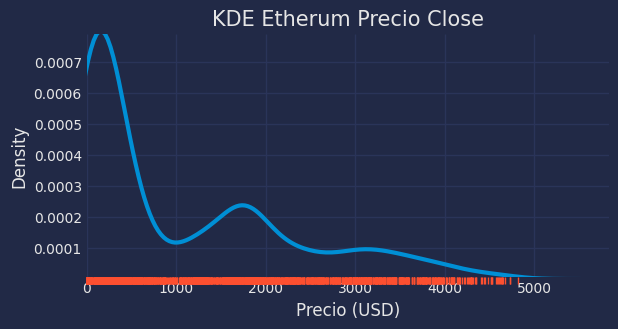

In [ ]:
set_dark_theme()
fig, ax = plt.subplots(figsize=(6, 3))
p = sns.kdeplot(data=data, x="Close", linewidth=3, ax=ax)
r = sns.rugplot(data=data, x="Close", ax=ax, height=-0.03, clip_on=False)
p.set(xlim=(0, None))
p.set_title("KDE Etherum Precio Close", fontsize=15)
p.set_xlabel("Precio (USD)");